BioVida: Open-i
========

[Open-i](https://openi.nlm.nih.gov) is an open access biomedical search engine provided by the US National Institutes of Health. The service grants programmatic access to its over 1.2 million images through a RESTful web API. BioVida provides an easy-to-use python interface for this web API, located in the ``images`` subpackage.

In [1]:
import qgrid
from utils import qshow
qgrid.nbinstall(overwrite=True)

Note: `utils` is a small script with some helpful functions located in the base of this directory. 

In [2]:
from biovida.images import OpeniInterface

Using Theano backend.


In [3]:
opi = OpeniInterface()

We start by creating an instance of the class. All BioVida interfaces accept at least two parameters: verbose and cache_path. The first simply determines whether or not the class provides you with additional updates as the class works. The second refers to the location where will be stored (or *cached*) on your computer. If left to its default, data will be cached in a directory entitled *biovida_cache* in your home directory. For most use cases, this should suffice.

---

### Searching

To search the Open-i database, we can use the ``OpeniInterface``'s ``search`` method. To explore valid values that can be passed to ``search``, we can use the ``options()``.

In [4]:
opi.options()

  - 'article_type'
  - 'collection'
  - 'exclusions'
  - 'fields'
  - 'image_type'
  - 'rankby'
  - 'specialties'
  - 'subset'
  - 'video'


The code above enumerates all of the parameters, apart from a specific ``query`` string, that can be passed to ``search()``. Additionally, ``options()`` can be used to investigate the valid values for any one of these parameters.

In [5]:
opi.options('collection')

  - 'history_of_medicine'
  - 'indiana_u_xray'
  - 'medpix'
  - 'pubmed'
  - 'usc_anatomy'


In [6]:
opi.options('image_type')

  - 'ct'
  - 'graphic'
  - 'microscopy'
  - 'mri'
  - 'pet'
  - 'photograph'
  - 'ultrasound'
  - 'x_ray'


Let's go ahead and perform a search for X-ray and CT images of 'lung cancer' from the PubMed collection/database.

In [7]:
opi.search(query='lung cancer', image_type=('x_ray', 'ct'), collection='pubmed')


Results Found: 8,531.


---

### Downloading Data

Now that we've defined a search, we can easily download some, or all, of the results found.
For the sake of expediency, let's limit the number of results we download to the first 1500.

In [8]:
pull_df = opi.pull(download_limit=1500)


Number of Records to Download: 1,500 (chunk size: 30 records).


The text information associated with images are referred to as 'records', which are downloaded in 'chunks' of no more than 30 at a time. <br>
Images, unlike records, are downloaded 'one by one'. However, ``pull()`` will check the cache before downloading an image, in an effort to reduce redundant downloads.

The dataframe generated by ``pull()`` can be viewed using either ``opi.records_db``, or the ``pull_df`` used above to capture the output of ``pull()``. Both will be identical. We can also view an abbreviated dataframe, ``opi.records_db_short``, which has several (typically unneeded) columns removed. 

In [9]:
def simplify_df(df):
    """This function simplifies dataframes
    for the purposes of this tutorial."""
    data_frame = df.copy()
    for c in ('parsed_abstract', 'query'):
        data_frame[c] = data_frame[c].map(lambda x: str(x) if str(x) != 'nan' else x)
    data_frame['cached_images_path'] = '/path/to/image'
    return data_frame[0:100]

In [10]:
qshow(simplify_df(opi.records_db_short))

This dataframe is provides a lot of rich data, which is valuable independent of the images which have also been downloaded. 

For instance, it is possible to quickly generate some descriptive statistics about our newly created 'lung cancer' dataset.

In [11]:
pull_df['age'].describe()

count    966.000000
mean      53.337267
std       21.999990
min        1.000000
25%       47.000000
50%       59.000000
75%       68.000000
max       91.400000
Name: age, dtype: float64

In [12]:
pull_df['sex'].value_counts(normalize=True)

male      0.722359
female    0.277641
Name: sex, dtype: float64

The `age` column in generated by analyzing the raw text provided by the Open-i RESTful API. It is reasonably accurate, but mistakes are certainly possible.

It should also be mentioned that ``opi.records_db`` *only* contains data for the most recent ``search()`` and ``pull()``. Conversely, **``cache_records_db``** provides a record of all images in the cache, e.g., those obtained several weeks ago.

---

### Images

Now that we've explored obtaining and reviewing data, we can finally turn our attention to images themselves.

In [13]:
from utils import show_image
%matplotlib inline

Using the ``show_images`` imported above, we can now look at a random images we pulled in the step above.

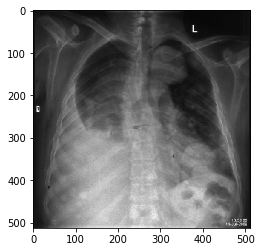

In [14]:
show_image(opi.records_db['cached_images_path'].iloc[156])

In [15]:
opi.records_db['license_type'].iloc[156]

'open-access'

Let's also look at the age and sex of this subject. 

In [16]:
age_sex = opi.records_db['age'].iloc[156], opi.records_db['sex'].iloc[156]
print("age: {0}, sex: {1}.".format(*age_sex))

age: 48.0, sex: male.


We can also easily check their diagnosis

In [17]:
opi.records_db['diagnosis'].iloc[156]

'carcinoma; neurofibromatosis'

Please be advised that for collections other than 'MedPix'\*, such as PubMed, diagnosis information is obtained by analyzing the text associated with the image. ***Errors are possible***.

\*MedPix explicitly provides diagnosis information, so it can be assumed to be accurate.  

---

### Automated Cleaning of Image Data (<font color='red'>Experimental</font>)

While the data may look OK so far, if we look more closely we will likely find several problems with the images we have downloaded.

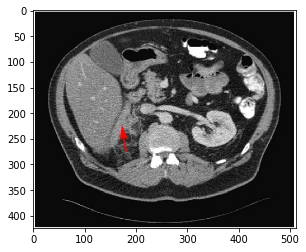

In [18]:
show_image(opi.records_db['cached_images_path'].iloc[100])

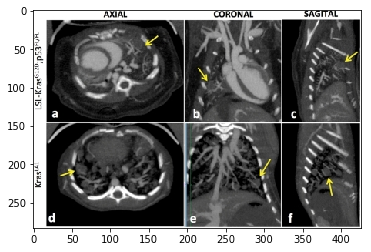

In [19]:
show_image(opi.records_db['cached_images_path'].iloc[10])

The images above contain several clear problems. They both contain arrows and the latter is actually a 'grid' of images. These are liable to confuse any model we attempt to train detect disease. We could manually go through and remove these images or, alternatively, we can use the *experimental* ``OpeniImageProcessing`` class to try and eliminate these images from our dataset automatically.

In [20]:
from biovida.images import OpeniImageProcessing

We initialize this class using our ``OpeniInterface`` instance.
By default, it will extract the `records_db` DataFrame. Do note, however, that we can force it to extract the ``cache_records_db`` DataFrame by setting the ``db_to_extract`` equal to 'cache_records_db'.

In [21]:
ip = OpeniImageProcessing(opi)

``OpeniImageProcessing`` will automatically download a model for a *Convolutional Neural Network* (convnet) which has been trained to detect these kinds of problems. If you are unfamiliar with these kinds of models, you can read more about them [here](http://cs231n.github.io/convolutional-networks/).

The ``OpeniImageProcessing`` class tries to detect problems in the images by analyzing both the text associated it is associated with as well as by feeding the image through the convnet mentioned above. However, by default the ``OpeniImageProcessing`` class will only use predictions gleaned from this model if it has been explicitly trained on images from that kind of [imaging modality](https://encrypted.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=16&ved=0ahUKEwjd3pbG0IvTAhUn5YMKHTFMDoYQygQIaTAP&url=https%3A%2F%2Fen.wikipedia.org%2Fwiki%2FMedical_imaging%23Imaging_modalities&usg=AFQjCNHL9pIw5HQ6bjdufkm1XbclcKyRXQ&sig2=c6SL1Ev2J8wM2JlQmrmjxw).

We can easily check the modalities for which the model has been trained:

In [22]:
ip.trained_open_i_modality_types

['ct', 'mri', 'x_ray']

Luckily, we're working with X-rays and CTs. <br>

Now we're ready to analyze our images.

In [23]:
analysis_df = ip.auto()

This will generate several new columns:


- **'grayscale'**: this is simply an account of whether or not the images is grayscale.
- **'medpix_logo_bounding_box'**: images from the MedPix collection, typically contain the organization's logo in the top right corner. Had we passed the class images from MedPix, it would have tried to 'draw' a bounding box around its precise location (enabling it to be cropped out of the image).
- **'hbar'**: this denotes a 'horizontal bar' that is sometimes found at the bottom of images. If present, this column reports its height in pixels.
- **'hborder'**: this column provides an account of 'horizontal borders' on either side of the image.
- **'vborder'**: this column provides an account of 'vertical borders' on the top and bottom of the image.
- **'upper crop'**: this is the location that has been selected to crop the top of the image. This decision is made by considering the *'medpix_logo_bounding_box'* and *'vborder'* columns.
- **'lower crop'**: this is the location that has been selected to crop the bottom of the image. This decision is made by considering the *'hbar'* and *'hborder'* columns.
- **'visual_image_problems'**: this column contains the output of the convnet model, with the numbers following the words representing the probability that the image belongs to that category.
- **'invalid_image'**: this is a decision as to whether or not the image is invalid, e.g., has an arrow. This decision is made using the 'grayscale' and *'visual_image_problems'* columns as well as the text associated with the image (*'image_problems_from_text'*)
- **'invalid_image_reasons'**: in cases where the *'invalid_image'* column is ``True``, column provides an account as to why a decision was made.




We can use this analysis to construct a new dataframe, with **'invalid_images'** removed and the remaining images cropped in such a way that problematic features are removed.

In [24]:
ip.clean_image_dataframe()

This refined set of 'cleaned' images *should* have reduced instances of problematic images.

Here's a random image from this new set:

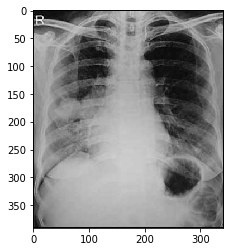

In [25]:
show_image(ip.image_dataframe_cleaned['cleaned_image'].iloc[180])

With time, the machinery used to detect these kinds of problems, particularly the convolutional neural network, will be improved. However, at the current time, **this class is still considered to be very experimental**.

---
### Train, Validation and Test

Now that we've explored data harvesting, we can turn our attention to the final step before modeling: dividing data into training, validation and tests sets.

Let's use images from the *Indiana University Chest X-Ray* collection ('indiana_u_xray'). This set of images has been assembled 'by hand', and thus does not require complicated image cleaning procedures.

In [26]:
opi.search(collection='indiana_u_xray')


Results Found: 7,470.


Let's go ahead and download this entire collection. <br>
Please be advised that this will take some time, so feel free to adjust ``download_limit`` to suit your needs.

In [27]:
pull_df2 = opi.pull(download_limit=None)


Number of Records to Download: 7,470 (chunk size: 30 records).


Let's quickly inspect this newly downloaded data.

In [28]:
qshow(simplify_df(opi.records_db_short))

We can easily select a subset of these ~7000 images and divide them into training and test sets for some machine learning model using the ``image_divvy()`` tool.

In [29]:
from biovida.images import image_divvy

Let's imagine we're interested in building a model capable of distinguishing between 'normal' chest x-rays and those with signs of problematic caclium deposits, a disease formally known as 'calcinosis'.

We can define a rule to construct such a training and test set using a 'divvy_rule'.
This rule will tell ``image_divvy()`` how to 'divvy up' the images in the cache. More specifically, our rule will tell this function how to test a row in the ``records_db`` database, to see if the image which it is associate with meets our criteria. If it does, we can place it in a category with a name of our choosing.

In [30]:
def my_divvy_rule(row):
    if isinstance(row['diagnosis'], str):
        if 'normal' in row['diagnosis']:
            return 'normal'  # though this could be anything, e.g., 'super cool normal image'.
        elif 'calcinosis' in row['diagnosis']:
            return 'calcinosis'

Now that ``image_divvy()`` knows how we would like it to categorize the data we've downloaded, we can also pass it a dictionary specifying how to 'split' the data into training and testing sets. In this example, we'll use a standard 80% train, 20% test split and ask the function returns numpy arrays (``ndarrays``) as output.

In [31]:
train_test = image_divvy(instance=opi,
                         divvy_rule=my_divvy_rule,
                         action='ndarray',
                         train_val_test_dict={'train': 0.8, 'test': 0.2})



Structure:

- 'train':
  - 'calcinosis'
  - 'normal'
- 'test':
  - 'calcinosis'
  - 'normal'


Before signing off, ``image_divvy()`` printed the structure of the nested dictionary it returned. 

We can use this information to unpack the ``arrays`` nested within this data structure:

In [32]:
train_ca, test_ca = train_test['train']['calcinosis'], train_test['test']['calcinosis']
train_norm, test_norm = train_test['train']['normal'], train_test['test']['normal']

Now that our data has been neatly unpacked, we can look at the number of samples the procedure generated.

In [33]:
# Normal
print("Train:", len(train_norm), "|", "Test:", len(test_norm))

Train: 522 | Test: 131


In [34]:
# Calcinosis
print("Train:", len(train_ca), "|", "Test:", len(test_ca))

Train: 446 | Test: 112


Using the ``show_image()`` tool we imported above, we can take a quick at an image from each category.

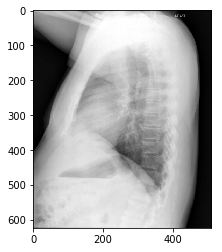

In [35]:
# Normal
show_image(train_norm[99])

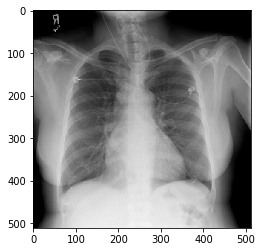

In [36]:
# Calcinosis
show_image(train_ca[104])

---

Here we've explored how ``BioVida`` can be used to easily obtain and process data from the Open-i database. <br>

In the next tutorial, we'll explore how ``BioVida`` can be used to gain access to a database with orders of magnitude more images.



---